# Pattern replacer for geqo

## Background
The pattern replacer is a tool that allows to automatically replace gates of a quantum circuit with other gates as specified by user-defined replacement rules, which we call pattern in the following.

For instance, two consecutive Pauli gates `PauliX()` on one qubit can be replaced by the idenitity. This means that `Sequence([0], [], [(PauliX(), [0], []), (PauliX(), [0], [])])` can be replaced by `Sequence([0], [], [])`. These two sequences can be used to define a pattern.

The pattern replacer comes along with tools to identify parts of circuits, that are suitable for a replacement. For instance, if there is another gate between the two `PauliX` gates, but operates on another qubit, then this gate can be filtered out. Furthermore, the tool contains a unification algorithm to match the names of bits, qubits and parameters of gates, which allows patterns to be applied to quantum circuits that use different names for these items.

In [1]:
from geqo.core import Sequence
from geqo.core import BasicGate, InverseBasicGate
from geqo.gates import PauliX, CNOT, Hadamard
from geqo.visualization import plot_latex
from geqo.simulators import ensembleSimulatorSymPy
from geqo.algorithms import (
    Pattern,
    findLongestRunSequence,
    getAllLongestRuns,
    getAllRuns,
)

## Example: Eliminate double PauliX
- a sequence of two PauliX gates can be reduced to no gates at all
- the pattern is defined with the input and the output sequence

In [2]:
inputSequence = Sequence([0], [], [(PauliX(), [0], []), (PauliX(), [0], [])])
outputSequence = Sequence([0], [], [])
lambdas = []

pat = Pattern("test1", inputSequence, outputSequence, lambdas)
print(pat)

Pattern #bits/#quits=0/1 and #lamdbas=0


- the input pattern can be replaced with the output pattern with the function `replacer`
- the name of the qubit is automatically matched with the corresponding name in the pattern, which allows the pattern to be applied

In [3]:
seq = Sequence(["a"], [], [(PauliX(), ["a"], []), (PauliX(), ["a"], [])])
newSeq, subst = pat.replacer(seq)
print("used subst=", subst)
print("newSeq=", newSeq)

check sequence
run ix= 0
set qubits 0 to value a
res1/res2= True {}
run ix= 1
res1/res2= True {}
res1/res2/resQ/resC= True {} {0: 'a'} {}
replace_recursion called for Sequence([0], [], [])
used subst= {}
newSeq= Sequence(['a'], [], [])


## Example: Replace two BasicGates with another one
- two basic gates with the same number of qubits can be merged into a single basic gate
- the unitary operation corresponding to the new gate is the product of the two unitary operations of the two original gates
- the definition of the parameter of the new gate can be obtained with lambda functions
- the lambda functions can be used for the `setValue` function of simulators

In [4]:
inputSequence = Sequence(
    [0], [], [(BasicGate("x1", 1), [0], []), (BasicGate("x2", 1), [0], [])]
)
outputSequence = Sequence([0], [], [(BasicGate("y1", 1), [0], [])])
lambdas = [("y1", lambda x1, x2: x2 * x1)]

pat = Pattern("test2", inputSequence, outputSequence, lambdas)
print(pat)

Pattern #bits/#quits=0/1 and #lamdbas=1


- the function `replacer` is used to apply the pattern
- the names `x1` and `x2` of the gates are automatically matched with the names `a` and `b` of the pattern

In [5]:
seq = Sequence([0], [], [(BasicGate("a", 1), [0], []), (BasicGate("b", 1), [0], [])])
newSeq, subst = pat.replacer(seq)
print("used subst=", subst)
print("newSeq=", newSeq)

check sequence
run ix= 0
set qubits 0 to value 0
check basic gate
add pattern.name/target.name= x1 a
res1/res2= True {'x1': 'a'}
run ix= 1
check basic gate
add pattern.name/target.name= x2 b
res1/res2= True {'x1': 'a', 'x2': 'b'}
res1/res2/resQ/resC= True {'x1': 'a', 'x2': 'b'} {0: 0} {}
replace_recursion called for Sequence([0], [], [(BasicGate("y1", 1), [0], [])])
replace_recursion called for BasicGate("y1", 1)
replace basic gate
used subst= {'x1': 'a', 'x2': 'b'}
newSeq= Sequence([0], [], [(BasicGate("y1", 1), [0], [])])


## Example: CNOT reversal with Hadamard gates
- a CNOT operation on qubits $q_0$ and $q_1$ can be turned into a CNOT on $q_1$ and $q_0$ by applying Hadamard gates before and after the gate

In [6]:
inputSequence = Sequence(
    [0, 1],
    [],
    [
        (Hadamard(), [0], []),
        (Hadamard(), [1], []),
        (CNOT(), [0, 1], []),
        (Hadamard(), [0], []),
        (Hadamard(), [1], []),
    ],
)
outputSequence = Sequence([0, 1], [], [(CNOT(), [1, 0], [])])
lambdas = []

pat = Pattern("test3", inputSequence, outputSequence, lambdas)
print(pat)

Pattern #bits/#quits=0/2 and #lamdbas=0


In [7]:
seq = Sequence(
    [1, 0],
    [],
    [
        (Hadamard(), [0], []),
        (Hadamard(), [1], []),
        (CNOT(), [0, 1], []),
        (Hadamard(), [0], []),
        (Hadamard(), [1], []),
    ],
)
newSeq, subst = pat.replacer(seq)
print("used subst=", subst)
print("newSeq=", newSeq)

check sequence
run ix= 0
set qubits 0 to value 0
res1/res2= True {}
run ix= 1
set qubits 1 to value 1
res1/res2= True {}
run ix= 2
res1/res2= True {}
run ix= 3
res1/res2= True {}
run ix= 4
res1/res2= True {}
res1/res2/resQ/resC= True {} {0: 0, 1: 1} {}
replace_recursion called for Sequence([0, 1], [], [(CNOT(), [1, 0], [])])
replace_recursion called for CNOT()
used subst= {}
newSeq= Sequence([0, 1], [], [(CNOT(), [1, 0], [])])


## Example: Reverse BasicGate and InverseBasicGate
- the order of a `BasicGate` and an `InverseBasicGate` can be reversed if both have the same name
- both correspond to unitaries $U$ and $U^\dagger$, which commute

In [8]:
inputSequence = Sequence(
    [0], [], [(BasicGate("X1", 1), [0], []), (InverseBasicGate("X1", 1), [0], [])]
)
outputSequence = Sequence(
    [0], [], [(InverseBasicGate("X1", 1), [0], []), (BasicGate("X1", 1), [0], [])]
)
lambdas = []

pat = Pattern("test4", inputSequence, outputSequence, lambdas)
print(pat)

Pattern #bits/#quits=0/1 and #lamdbas=0


In [9]:
seq = Sequence(
    ["a"], [], [(BasicGate("u", 1), ["a"], []), (InverseBasicGate("u", 1), ["a"], [])]
)
newSeq, subst = pat.replacer(seq)
print("used subst=", subst)
print("newSeq=", newSeq)

check sequence
run ix= 0
set qubits 0 to value a
check basic gate
add pattern.name/target.name= X1 u
res1/res2= True {'X1': 'u'}
run ix= 1
check basic gate
res1/res2= True {'X1': 'u'}
res1/res2/resQ/resC= True {'X1': 'u'} {0: 'a'} {}
replace_recursion called for Sequence([0], [], [(InverseBasicGate("X1", 1), [0], []), (BasicGate("X1", 1), [0], [])])
replace_recursion called for InverseBasicGate("X1", 1)
replace inverse basic gate
replace_recursion called for BasicGate("X1", 1)
replace basic gate
used subst= {'X1': 'u'}
newSeq= Sequence(['a'], [], [(InverseBasicGate("u", 1), ['a'], []), (BasicGate("u", 1), ['a'], [])])


## Finding candidates in a given sequence
- assume that we want to find sub-circuits on two qubits
- if a qubit has a gate with an outsider qubit then it is burned

In [10]:
# The first qubit should lead to two Hadamard gates.
# The second qubit should get burned because of the gate with qubit 2.
seq = Sequence(
    ["0", "1", "2"],
    [],
    [
        (Hadamard(), ["0"], []),
        (Hadamard(), ["1"], []),
        (CNOT(), ["1", "2"], []),
        (Hadamard(), ["0"], []),
    ],
)

In [11]:
findLongestRunSequence(seq, 0, ["0", "1"])

(Sequence(['0', '1'], [], [(Hadamard(), ['0'], []), (Hadamard(), ['1'], []), (Hadamard(), ['0'], [])]),
 [0, 1, 3])

## A more complex example

In [12]:
seq = Sequence(
    [0, 1, 2, 3],
    [],
    [
        (Hadamard(), [0], []),
        (CNOT(), [1, 2], []),
        (CNOT(), [2, 3], []),
        (CNOT(), [0, 2], []),
        (Hadamard(), [0], []),
        (Hadamard(), [1], []),
    ],
)
findLongestRunSequence(seq, 0, [0, 1, 2])

(Sequence([0, 1, 2], [], [(Hadamard(), [0], []), (CNOT(), [1, 2], []), (Hadamard(), [1], [])]),
 [0, 1, 5])

## Automatically applying the reversal pattern with gates in between

In [13]:
inputSequence = Sequence(
    [0, 1],
    [],
    [
        (Hadamard(), [0], []),
        (Hadamard(), [1], []),
        (CNOT(), [0, 1], []),
        (Hadamard(), [0], []),
        (Hadamard(), [1], []),
    ],
)
outputSequence = Sequence([0, 1], [], [(CNOT(), [1, 0], [])])
lambdas = []

pat = Pattern("Hadamard upside-down", inputSequence, outputSequence, lambdas)
print(pat)

Pattern #bits/#quits=0/2 and #lamdbas=0


In [14]:
seq = Sequence(
    ["0", "1", "2", "3"],
    [],
    [
        (Hadamard(), ["0"], []),
        (Hadamard(), ["2"], []),
        (CNOT(), ["1", "3"], []),
        (CNOT(), ["0", "2"], []),
        (CNOT(), ["3", "1"], []),
        (Hadamard(), ["0"], []),
        (Hadamard(), ["2"], []),
    ],
)
subseq, indexes = findLongestRunSequence(seq, 0, ["0", "2"])

In [15]:
print(subseq)
print(indexes)

Sequence(['0', '2'], [], [(Hadamard(), ['0'], []), (Hadamard(), ['2'], []), (CNOT(), ['0', '2'], []), (Hadamard(), ['0'], []), (Hadamard(), ['2'], [])])
[0, 1, 3, 5, 6]


In [16]:
newSeq, subst = pat.replacer(subseq)
print(newSeq)

check sequence
run ix= 0
set qubits 0 to value 0
res1/res2= True {}
run ix= 1
set qubits 1 to value 2
res1/res2= True {}
run ix= 2
res1/res2= True {}
run ix= 3
res1/res2= True {}
run ix= 4
res1/res2= True {}
res1/res2/resQ/resC= True {} {0: '0', 1: '2'} {}
replace_recursion called for Sequence([0, 1], [], [(CNOT(), [1, 0], [])])
replace_recursion called for CNOT()
Sequence(['0', '2'], [], [(CNOT(), ['2', '0'], [])])


## Example: A CNOT reversal operation with other gates between

In [2]:
# The Hadamard conjugation of a CNOT leads to a flipped CNOT.

inputSequence = Sequence(
    [0, 1],
    [],
    [
        (Hadamard(), [0], []),
        (Hadamard(), [1], []),
        (CNOT(), [0, 1], []),
        (Hadamard(), [0], []),
        (Hadamard(), [1], []),
    ],
)
outputSequence = Sequence([0, 1], [], [(CNOT(), [1, 0], [])])
lambdas = []

pat = Pattern("Hadamard Upside-Down", inputSequence, outputSequence, lambdas)
print(pat)

Pattern #bits/#quits=0/2 and #lamdbas=0


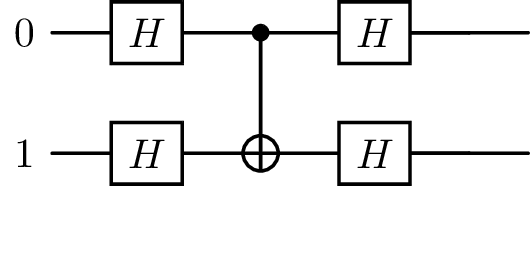

In [3]:
sim = ensembleSimulatorSymPy(3, 0)
plot_latex(inputSequence, backend=sim, greek_symbol=True)

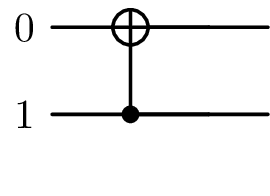

In [4]:
sim = ensembleSimulatorSymPy(3, 0)
plot_latex(outputSequence, backend=sim, greek_symbol=True)

In [5]:
seq = Sequence(
    ["0", "1", "2", "3"],
    [],
    [
        (Hadamard(), ["0"], []),
        (Hadamard(), ["2"], []),
        (CNOT(), ["1", "3"], []),
        (CNOT(), ["3", "1"], []),
        (Hadamard(), ["1"], []),
        (CNOT(), ["0", "2"], []),
        (Hadamard(), ["0"], []),
        (Hadamard(), ["3"], []),
        (Hadamard(), ["2"], []),
    ],
)

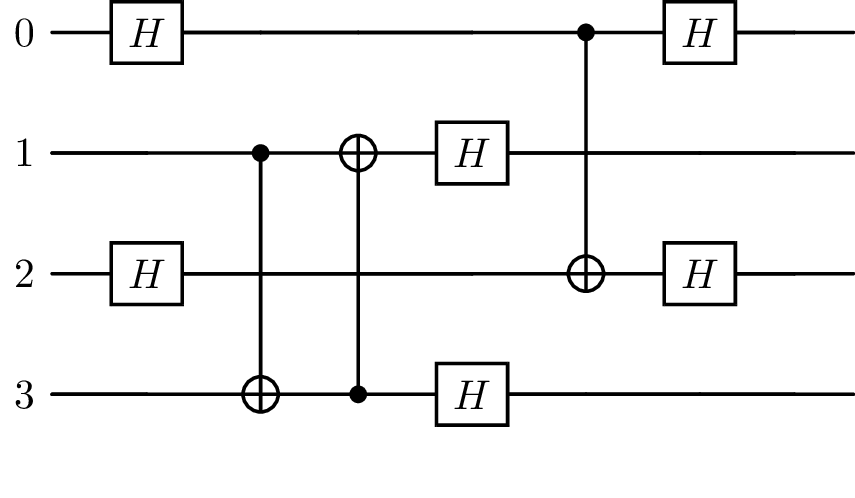

In [6]:
sim = ensembleSimulatorSymPy(3, 0)
plot_latex(seq, backend=sim, greek_symbol=True)

In [7]:
subseq, indexes = findLongestRunSequence(seq, 0, ["0", "2"])
print(subseq)
print(indexes)

Sequence(['0', '2'], [], [(Hadamard(), ['0'], []), (Hadamard(), ['2'], []), (CNOT(), ['0', '2'], []), (Hadamard(), ['0'], []), (Hadamard(), ['2'], [])])
[0, 1, 5, 6, 8]


check sequence
run ix= 0
set qubits 0 to value 0
res1/res2= True {}
run ix= 1
set qubits 1 to value 2
res1/res2= True {}
run ix= 2
res1/res2= True {}
run ix= 3
res1/res2= True {}
run ix= 4
res1/res2= True {}
res1/res2/resQ/resC= True {} {0: '0', 1: '2'} {}
replace_recursion called for Sequence([0, 1], [], [(CNOT(), [1, 0], [])])
replace_recursion called for CNOT()
Sequence(['0', '2'], [], [(CNOT(), ['2', '0'], [])])
{}


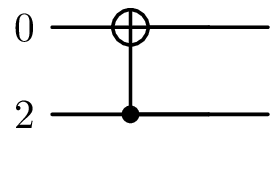

In [8]:
newSeq, subst = pat.replacer(subseq)
print(newSeq)
print(subst)
sim = ensembleSimulatorSymPy(3, 0)
plot_latex(newSeq, backend=sim, greek_symbol=True)

- Replace the gates in the original sequence directly

we eliminate the indexes: [0, 1, 5, 6, 8]
place in: (CNOT(), ['2', '0'], [])


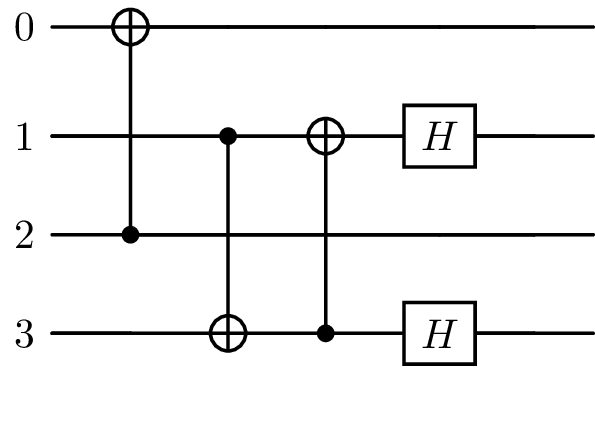

In [9]:
startIndex = 0  # We started here
print("we eliminate the indexes:", indexes)
newGatesAndTargets = []
for gi in range(len(seq.gatesAndTargets)):
    # The first hit with our pattern is replaces
    if gi == min(indexes):
        # We have to place the substitution circuit here.
        for g in newSeq.gatesAndTargets:
            print("place in:", g)
            newGatesAndTargets.append(g)

    if gi not in indexes:
        newGatesAndTargets.append(seq.gatesAndTargets[gi])

replacesSeq = Sequence(seq.qubits, seq.bits, newGatesAndTargets)

sim = ensembleSimulatorSymPy(3, 0)
plot_latex(replacesSeq, backend=sim, greek_symbol=True)

## Scan a whole circuit for a pattern
- the function `getAllLongestRuns` takes a sequence and a number of qubits as inputs
- the functions considers all possible combination of qubits with the specified number of qubits
- for each combination of qubits, the longest possible sequences on these qubits are returned
- a sequence cannot be extended on a qubit if there is a gate including a qubit, which is not part of the combination under consideration
-  in the following example, we get the longest possible subsequences on all pairs of qubits

In [10]:
seq = Sequence(
    ["0", "1", "2", "3"],
    [],
    [
        (Hadamard(), ["0"], []),
        (Hadamard(), ["2"], []),
        (CNOT(), ["1", "3"], []),
        (CNOT(), ["3", "1"], []),
        (Hadamard(), ["1"], []),
        (CNOT(), ["0", "2"], []),
        (Hadamard(), ["0"], []),
        (Hadamard(), ["3"], []),
        (Hadamard(), ["2"], []),
    ],
)
getAllLongestRuns(seq, 2)

[(('0', '1'), [0]),
 (('0', '1'), [4]),
 (('0', '1'), [6]),
 (('0', '2'), [0, 1, 5, 6, 8]),
 (('0', '3'), [0]),
 (('0', '3'), [7]),
 (('1', '2'), [1]),
 (('1', '2'), [4]),
 (('1', '2'), [8]),
 (('1', '3'), [2, 3, 4, 7]),
 (('2', '3'), [1]),
 (('2', '3'), [7]),
 (('2', '3'), [8])]

- in the following example, we get the longest possible sequences on single qubits
- the CNOT operation prevents sequences from being extended because the other qubit is used

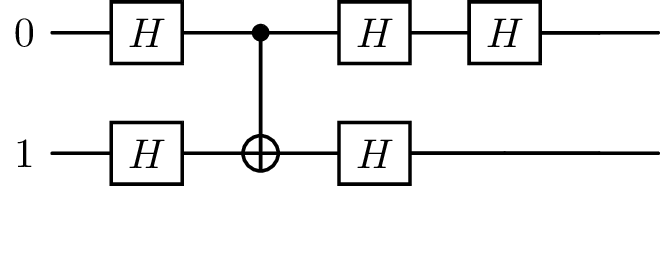

[(('0',), [0]), (('0',), [3, 5]), (('1',), [1]), (('1',), [4])]

In [11]:
seq = Sequence(
    ["0", "1"],
    [],
    [
        (Hadamard(), ["0"], []),
        (Hadamard(), ["1"], []),
        (CNOT(), ["0", "1"], []),
        (Hadamard(), ["0"], []),
        (Hadamard(), ["1"], []),
        (Hadamard(), ["0"], []),
    ],
)
sim = ensembleSimulatorSymPy(3, 0)
plot_latex(seq, backend=sim, greek_symbol=True)
getAllLongestRuns(seq, 1)

- the result shows that only single Hadamard gates can be seen as a continuous sequence except for the two consecutive Hadamard gates on the first qubit
- in the following example, the function `getAllRuns` is used to get sequences on the specified number of qubits of a specific length
- this function is useful to find all possible candidates to apply a specific pattern, i.e. the number of qubits and gates can be specified

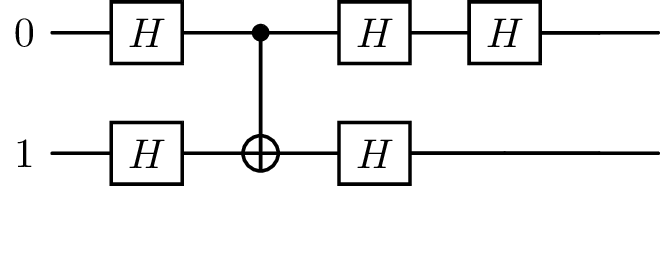

scan qubits ('0', '1')
longest run: [0, 1, 2, 3, 4, 5]
processing candidate (('0', '1'), [0, 1, 2, 3, 4, 5]) len(candGates)/numberGates 6 4
new candidate: (('0', '1'), [0, 1, 2, 3])
new candidate: (('0', '1'), [1, 2, 3, 4])
new candidate: (('0', '1'), [2, 3, 4, 5])


[(('0', '1'), [0, 1, 2, 3]),
 (('0', '1'), [1, 2, 3, 4]),
 (('0', '1'), [2, 3, 4, 5])]

In [12]:
# The same as above, but we can ask for a length of the sub-sequence. For instance, if we have [0,1,2] as max.
# run and we have 2 as number of qubits, we get [0,1] and [1,2] at the end.
seq = Sequence(
    ["0", "1"],
    [],
    [
        (Hadamard(), ["0"], []),
        (Hadamard(), ["1"], []),
        (CNOT(), ["0", "1"], []),
        (Hadamard(), ["0"], []),
        (Hadamard(), ["1"], []),
        (Hadamard(), ["0"], []),
    ],
)
sim = ensembleSimulatorSymPy(3, 0)
plot_latex(seq, backend=sim, greek_symbol=True)
getAllRuns(seq, 2, 4, True)

## Example: Replacement of Toffoli gates
- a Toffoli gate can be decomposed into single qubit gates (Hadamard, $T$ and $T^\dagger$ gates) and 6 CNOT gates
- for instance, see `https://en.wikipedia.org/wiki/Toffoli_gate#Related_logic_gates`
- as an example, we replace three Toffoli gates step by step
- the Toffoli gates act on different qubits and the pattern matcher automatically adapts the patterns to the different qubits

In [13]:
from geqo.gates import Toffoli

inputSequence = Sequence([0, 1, 2], [], [(Toffoli(), [0, 1, 2], [])])
outputSequence = Sequence(
    [0, 1, 2],
    [],
    [
        (Hadamard(), [2], []),
        (CNOT(), [1, 2], []),
        (InverseBasicGate("pi4", 1), [2], []),
        (CNOT(), [0, 2], []),
        (BasicGate("pi4", 1), [2], []),
        (CNOT(), [1, 2], []),
        (InverseBasicGate("pi4", 1), [2], []),
        (CNOT(), [0, 2], []),
        (BasicGate("pi4", 1), [1], []),
        (BasicGate("pi4", 1), [2], []),
        (CNOT(), [0, 1], []),
        (Hadamard(), [2], []),
        (BasicGate("pi4", 1), [0], []),
        (InverseBasicGate("pi4", 1), [1], []),
        (CNOT(), [0, 1], []),
    ],
)
lambdas = []

pat = Pattern(
    "toffoli",
    inputSequence,
    outputSequence,
    lambdas,
)
print(pat)

Pattern #bits/#quits=0/3 and #lamdbas=0


- in the following diagram, we visualize the gates that replace a Toffoli gate
- the BasicGates with the name `pi/4` correspond to $T$ gates

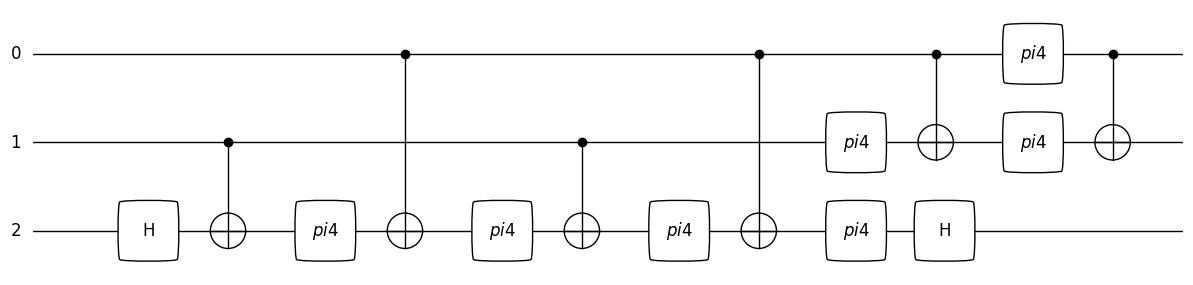

In [14]:
from geqo.visualization import plot_mpl

sim = ensembleSimulatorSymPy(3, 0)
plot_mpl(outputSequence, backend=sim, greek_symbol=True)

- we consider a sequence of 3 Toffoli gates
- each gate should be replaced by the replacement sequence

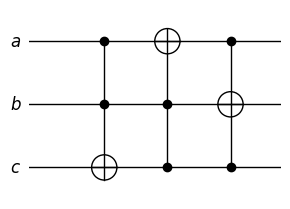

In [15]:
seq = Sequence(
    ["a", "b", "c"],
    [],
    [
        (Toffoli(), ["a", "b", "c"], []),
        (Toffoli(), ["b", "c", "a"], []),
        (Toffoli(), ["c", "a", "b"], []),
    ],
)
sim = ensembleSimulatorSymPy(3, 0)
plot_mpl(seq, backend=sim, greek_symbol=True)

- we construct the replacement sequences for the first gate
- the qubits are matched automatically
- if there were parameters like rotation angles, these would also be matches automatically

In [16]:
newSeq1, subst1 = pat.replacer(
    Sequence(["a", "b", "c"], [], [(Toffoli(), ["a", "b", "c"], [])])
)

check sequence
run ix= 0
set qubits 0 to value a
set qubits 1 to value b
set qubits 2 to value c
res1/res2= True {}
res1/res2/resQ/resC= True {} {0: 'a', 1: 'b', 2: 'c'} {}
replace_recursion called for Sequence([0, 1, 2], [], [(Hadamard(), [2], []), (CNOT(), [1, 2], []), (InverseBasicGate("pi4", 1), [2], []), (CNOT(), [0, 2], []), (BasicGate("pi4", 1), [2], []), (CNOT(), [1, 2], []), (InverseBasicGate("pi4", 1), [2], []), (CNOT(), [0, 2], []), (BasicGate("pi4", 1), [1], []), (BasicGate("pi4", 1), [2], []), (CNOT(), [0, 1], []), (Hadamard(), [2], []), (BasicGate("pi4", 1), [0], []), (InverseBasicGate("pi4", 1), [1], []), (CNOT(), [0, 1], [])])
replace_recursion called for Hadamard()
replace_recursion called for CNOT()
replace_recursion called for InverseBasicGate("pi4", 1)
replace inverse basic gate
replace_recursion called for CNOT()
replace_recursion called for BasicGate("pi4", 1)
replace basic gate
replace_recursion called for CNOT()
replace_recursion called for InverseBasicGate("pi4

- the replacement sequence for the first Toffoli gate is now stored in `newSeq1`
- with the following loop, the first gate of a matched pattern is replaced by the replacement sequence
- the further gates of a matched pattern are ignored, because the gates are replaced by other gates

we eliminate the indexes: [0]
place in: (Hadamard(), ['c'], [])
place in: (CNOT(), ['b', 'c'], [])
place in: (InverseBasicGate("pi4", 1), ['c'], [])
place in: (CNOT(), ['a', 'c'], [])
place in: (BasicGate("pi4", 1), ['c'], [])
place in: (CNOT(), ['b', 'c'], [])
place in: (InverseBasicGate("pi4", 1), ['c'], [])
place in: (CNOT(), ['a', 'c'], [])
place in: (BasicGate("pi4", 1), ['b'], [])
place in: (BasicGate("pi4", 1), ['c'], [])
place in: (CNOT(), ['a', 'b'], [])
place in: (Hadamard(), ['c'], [])
place in: (BasicGate("pi4", 1), ['a'], [])
place in: (InverseBasicGate("pi4", 1), ['b'], [])
place in: (CNOT(), ['a', 'b'], [])


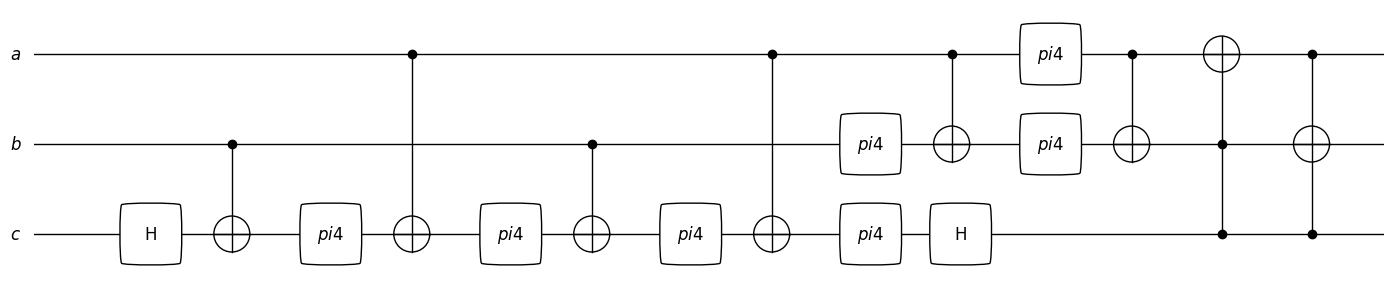

In [17]:
indexes = [0]  # Replace the first Toffoli

startIndex = 0  # We started here
print("we eliminate the indexes:", indexes)
newGatesAndTargets = []
for gi in range(len(seq.gatesAndTargets)):
    # The first hit with our pattern is replaces
    if gi == min(indexes):
        # We have to place the substitution circuit here.
        for g in newSeq1.gatesAndTargets:
            print("place in:", g)
            newGatesAndTargets.append(g)

    if gi not in indexes:
        newGatesAndTargets.append(seq.gatesAndTargets[gi])

replacesSeq = Sequence(seq.qubits, seq.bits, newGatesAndTargets)

sim = ensembleSimulatorSymPy(3, 0)
plot_mpl(replacesSeq, backend=sim, greek_symbol=True)

- we now create the replacement gates for the second Toffoli gate

In [19]:
newSeq2, subst2 = pat.replacer(
    Sequence(["a", "b", "c"], [], [(Toffoli(), ["b", "c", "a"], [])])
)

check sequence
run ix= 0
set qubits 0 to value b
set qubits 1 to value c
set qubits 2 to value a
res1/res2= True {}
res1/res2/resQ/resC= True {} {0: 'b', 1: 'c', 2: 'a'} {}
replace_recursion called for Sequence([0, 1, 2], [], [(Hadamard(), [2], []), (CNOT(), [1, 2], []), (InverseBasicGate("pi4", 1), [2], []), (CNOT(), [0, 2], []), (BasicGate("pi4", 1), [2], []), (CNOT(), [1, 2], []), (InverseBasicGate("pi4", 1), [2], []), (CNOT(), [0, 2], []), (BasicGate("pi4", 1), [1], []), (BasicGate("pi4", 1), [2], []), (CNOT(), [0, 1], []), (Hadamard(), [2], []), (BasicGate("pi4", 1), [0], []), (InverseBasicGate("pi4", 1), [1], []), (CNOT(), [0, 1], [])])
replace_recursion called for Hadamard()
replace_recursion called for CNOT()
replace_recursion called for InverseBasicGate("pi4", 1)
replace inverse basic gate
replace_recursion called for CNOT()
replace_recursion called for BasicGate("pi4", 1)
replace basic gate
replace_recursion called for CNOT()
replace_recursion called for InverseBasicGate("pi4

- we replace the first remaining Toffoli gate with the appropriate sequence

we eliminate the indexes: [15]
place in: (Hadamard(), ['a'], [])
place in: (CNOT(), ['c', 'a'], [])
place in: (InverseBasicGate("pi4", 1), ['a'], [])
place in: (CNOT(), ['b', 'a'], [])
place in: (BasicGate("pi4", 1), ['a'], [])
place in: (CNOT(), ['c', 'a'], [])
place in: (InverseBasicGate("pi4", 1), ['a'], [])
place in: (CNOT(), ['b', 'a'], [])
place in: (BasicGate("pi4", 1), ['c'], [])
place in: (BasicGate("pi4", 1), ['a'], [])
place in: (CNOT(), ['b', 'c'], [])
place in: (Hadamard(), ['a'], [])
place in: (BasicGate("pi4", 1), ['b'], [])
place in: (InverseBasicGate("pi4", 1), ['c'], [])
place in: (CNOT(), ['b', 'c'], [])


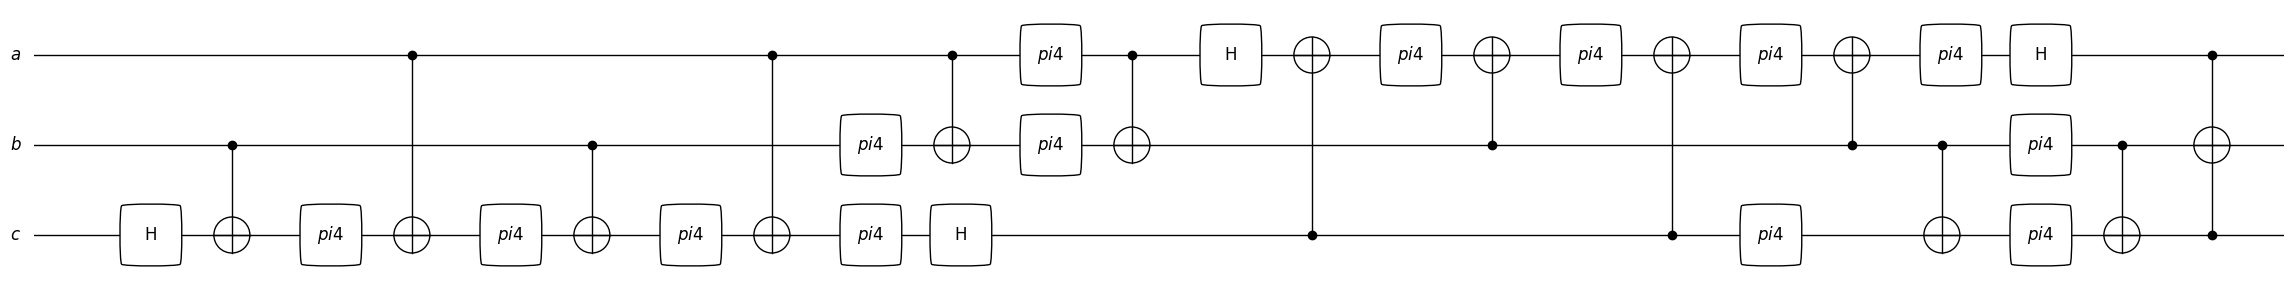

In [20]:
indexes = [15]  # Replace the first Toffoli

startIndex = 0  # We started here
print("we eliminate the indexes:", indexes)
newGatesAndTargets = []
for gi in range(len(replacesSeq.gatesAndTargets)):
    # The first hit with our pattern is replaces
    if gi == min(indexes):
        # We have to place the substitution circuit here.
        for g in newSeq2.gatesAndTargets:
            print("place in:", g)
            newGatesAndTargets.append(g)

    if gi not in indexes:
        newGatesAndTargets.append(replacesSeq.gatesAndTargets[gi])

replacesSeq = Sequence(replacesSeq.qubits, replacesSeq.bits, newGatesAndTargets)

sim = ensembleSimulatorSymPy(3, 0)
plot_mpl(replacesSeq, backend=sim, greek_symbol=True)

- we create the replacement sequence for the remaining Toffoli gate

In [21]:
newSeq3, subst3 = pat.replacer(
    Sequence(["a", "b", "c"], [], [(Toffoli(), ["c", "a", "b"], [])])
)

check sequence
run ix= 0
set qubits 0 to value c
set qubits 1 to value a
set qubits 2 to value b
res1/res2= True {}
res1/res2/resQ/resC= True {} {0: 'c', 1: 'a', 2: 'b'} {}
replace_recursion called for Sequence([0, 1, 2], [], [(Hadamard(), [2], []), (CNOT(), [1, 2], []), (InverseBasicGate("pi4", 1), [2], []), (CNOT(), [0, 2], []), (BasicGate("pi4", 1), [2], []), (CNOT(), [1, 2], []), (InverseBasicGate("pi4", 1), [2], []), (CNOT(), [0, 2], []), (BasicGate("pi4", 1), [1], []), (BasicGate("pi4", 1), [2], []), (CNOT(), [0, 1], []), (Hadamard(), [2], []), (BasicGate("pi4", 1), [0], []), (InverseBasicGate("pi4", 1), [1], []), (CNOT(), [0, 1], [])])
replace_recursion called for Hadamard()
replace_recursion called for CNOT()
replace_recursion called for InverseBasicGate("pi4", 1)
replace inverse basic gate
replace_recursion called for CNOT()
replace_recursion called for BasicGate("pi4", 1)
replace basic gate
replace_recursion called for CNOT()
replace_recursion called for InverseBasicGate("pi4

- finally, we can replace the last of the Toffoli gates with the sequence

we eliminate the indexes: [30]
place in: (Hadamard(), ['b'], [])
place in: (CNOT(), ['a', 'b'], [])
place in: (InverseBasicGate("pi4", 1), ['b'], [])
place in: (CNOT(), ['c', 'b'], [])
place in: (BasicGate("pi4", 1), ['b'], [])
place in: (CNOT(), ['a', 'b'], [])
place in: (InverseBasicGate("pi4", 1), ['b'], [])
place in: (CNOT(), ['c', 'b'], [])
place in: (BasicGate("pi4", 1), ['a'], [])
place in: (BasicGate("pi4", 1), ['b'], [])
place in: (CNOT(), ['c', 'a'], [])
place in: (Hadamard(), ['b'], [])
place in: (BasicGate("pi4", 1), ['c'], [])
place in: (InverseBasicGate("pi4", 1), ['a'], [])
place in: (CNOT(), ['c', 'a'], [])


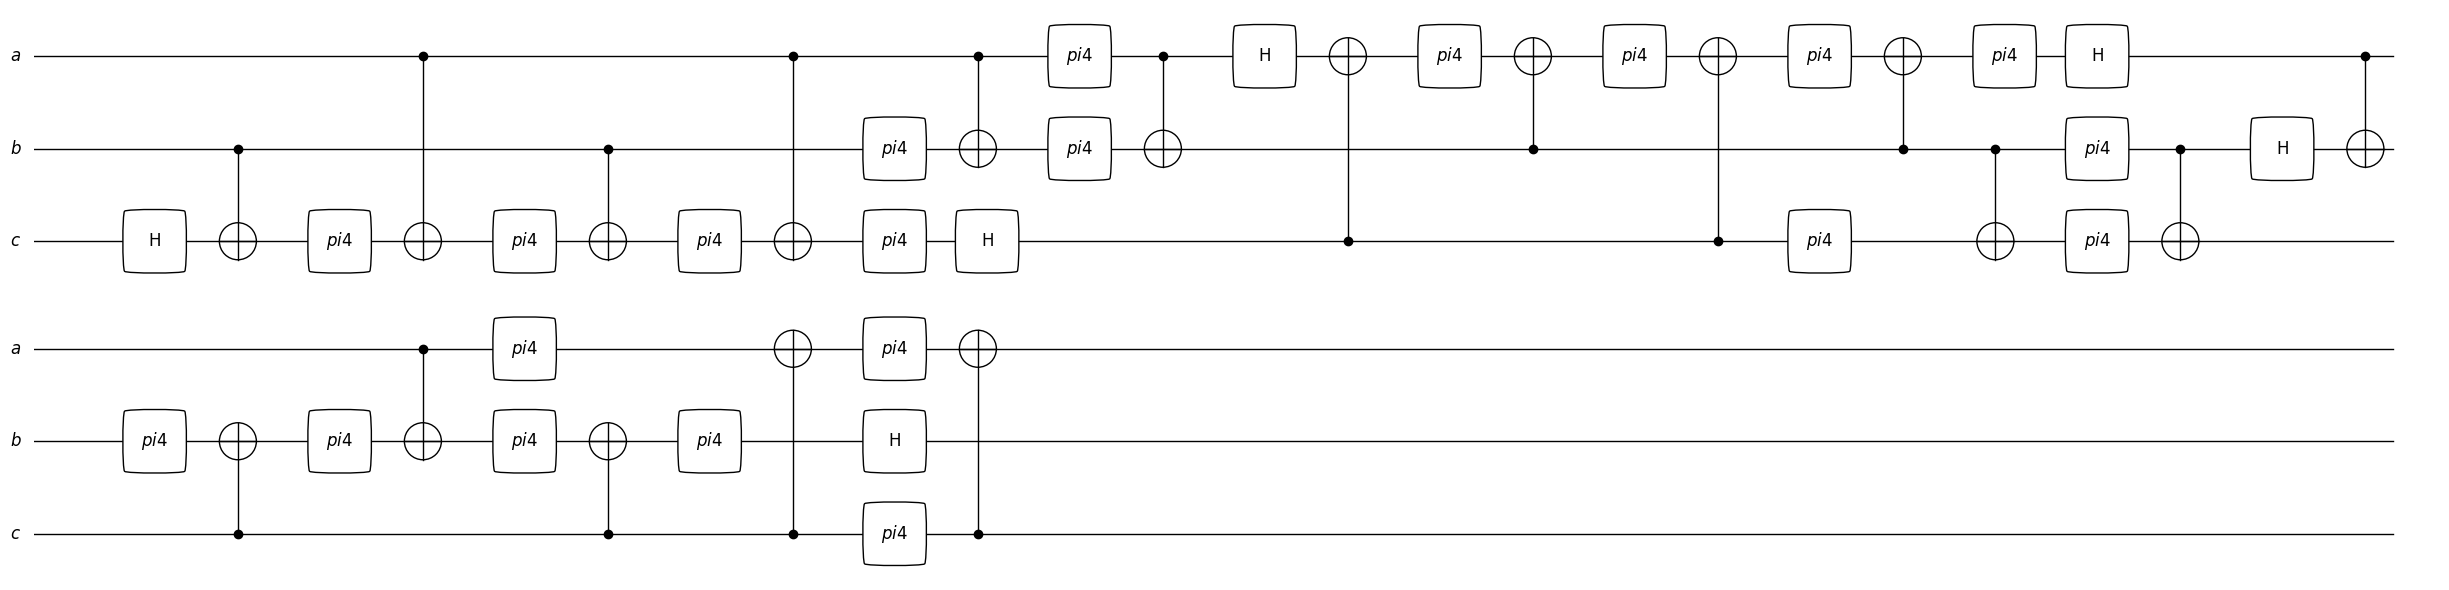

In [22]:
indexes = [30]  # Replace the first Toffoli

startIndex = 0  # We started here
print("we eliminate the indexes:", indexes)
newGatesAndTargets = []
for gi in range(len(replacesSeq.gatesAndTargets)):
    # The first hit with our pattern is replaces
    if gi == min(indexes):
        # We have to place the substitution circuit here.
        for g in newSeq3.gatesAndTargets:
            print("place in:", g)
            newGatesAndTargets.append(g)

    if gi not in indexes:
        newGatesAndTargets.append(replacesSeq.gatesAndTargets[gi])

replacesSeq = Sequence(replacesSeq.qubits, replacesSeq.bits, newGatesAndTargets)

sim = ensembleSimulatorSymPy(3, 0)
plot_mpl(replacesSeq, backend=sim, greek_symbol=True)

- the result shows that the qubits of the replacement pattern of a Toffoli gate were automatically matched with the corresponding qubits of the Toffoli gates